# Bond Returns and Risks

_The essence of investment management is the management of risks, not the management of returns_ - Benjamin Graham 

Concepts
- Term structure changes
- Bond risk factors

References:
- FRM Part I Exam Book Valuation and Risk Models Ch12-13

In [1]:
from typing import List
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from finds.readers import Alfred
from finds.recipes import bond_price
from secret import credentials
# %matplotlib qt
VERBOSE = 0

## Term structure changes

### Duration

Duration, or Macaulay Durection, measures the change in bond price P with
a instataneous change in its yield y. 

Consider a bond with price $P$ and yield $y$. Because it leads to a simpler duration formula, we first measure the yield with continuous compounding. The present value relationship between $P$ and $y$ is $P = \sum_{t=1}^{n} c_t e^{-yt}$.  Then after differentiating: $\Delta P = -\sum_{t=1}^{n} c_t t e^{-yt} \Delta y$

We define the yield-based duration as the proportional change in the
bond price for a small change in the yield: 

$$D = \dfrac{\Delta P}{P \Delta y} = \sum_{t=1}^{n} t \dfrac{c_t e^{-yt}}{P}$$

This formulation gives us another interpretation of duration. It
can be calculated by taking an average of the times when cash flows
are received weighted by the proportion of the bond’s value received
at each time. Duration is therefore a measure of how long an
investor has to wait to receive cash flows. (This explains why the
word “duration” was chosen to describe the sensitivity of proportional
changes to yield).

Modified duration: If the yield on the bond is measured with
semi-annual compounding rather than continuous compounding, the
expression for (Macaulay) duration must be divided by $(1 + y_2/2)$ 
(or $1 + y_m/m$ for m'thly compounding).

Effective duration describes the percentage change in the price of a
bond with embedded options due to a small change in all rates.




### DV01

DV01 describes the impact of a one-basis-point change in interest
rates on the value of a portfolio. 

$$DV01 = -\dfrac{\Delta P}{\Delta r}$$

where $\Delta r$ is the size of a small parallel shift
in the interest rate term structure (measured in basis points).




### Convexity

Bond duration and convexity are in the first two terms of the
derivative of a bond's price with respect to interest rates in a Taylor
expansion. Convexity measures the curvature of
the bond price-interest rate relationship. It indicates how much the
bond's duration changes as interest rates change. While duration helps
estimate bond price changes for small interest rate movements,
convexity accounts for larger changes, providing a more accurate
prediction of bond price behavior

Yield-based convexity when yields are expressed with continuous compounding is

$$C = \frac{1}{P}\frac{1}{(1+r/m)^2}\sum_{t=1}^{T}(t/2m +(t/m)^2)\frac{C_t}{(1+r/m)^t}$$

It is a weighted average of the squared time to maturity. When yields
are expressed with semi-annual compounding, these expressions must be
divided by $(1 + y_2/2)^2$ (or $(1 + y_m/2)^2$ with m'thly compounding) 
and the result is referred to as modified convexity.
Effective convexity measures the sensitivity of the duration measure
to changes in interest rates. 

$$C = \dfrac{1}{P}[\dfrac{P^+ + P^- - 2P}{(\Delta r)^2}]$$




In [2]:
# Helpers to calculate duration and convexity
def macaulay_duration(coupon: float, n: int, m: int, price: float, 
                      yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute macaulay duration of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Macaulay duration
    """
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same spot rate every period
    assert len(yields) == n, "Number of spot rates must equal number of couponds"
    pv = [(1 + yields[t-1]/m)**(-t) * (t/m) * (coupon/m + par*(t == n))
          for t in range(1, n+1)]    # discount every period's time-weighted payment
    return np.sum(pv) / price

In [3]:
def modified_duration(coupon: float, n: int, m: int, price: float, 
                      yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute modified duration of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Modified duration
    """
    assert not pd.api.types.is_list_like(yields), "Not Implemented"
    ytm = yields
    return (macaulay_duration(coupon=coupon, n=n, m=m, price=price, yields=yields, par=par)
            / (1 + ytm/2))

In [4]:
def modified_convexity(coupon: float, n: int, m: int, price: float, 
                       yields: float | List[float], par: float = 1, **kwargs) -> float:
    """Compute mocified convexity of a bond given spot rates or yield-to-maturity

    Args:
      coupon : Annual coupon rate
      n : Number of remaining coupons
      m : Number of compounding periods per year
      price : current market price of bond
      yields : Simple annual yield-to-maturity or spot rates each period
      par : face or par value of bond

    Returns:
      Modified convexity
    """
    assert not pd.api.types.is_list_like(yields), "Not Implemented"
    ytm = yields
    if not pd.api.types.is_list_like(yields):
        yields = [yields] * n        # same spot rate every period
    assert len(yields) == n, "Number of spot rates must equal number of coupons"
    pv = [(1 + yields[t-1]/m)**(-t) * ((t/m)**2 + t/(2*m)) * (coupon/m + par*(t == n))
          for t in range(1, n+1)]    # discount every period's time-weighted payment
    return np.sum(pv) / (price * (1 + ytm/m)**2)

### Barbells and bullets

In [5]:
# Compute prices, duration and convexity for 3 bonds (FRM Valuation and Risk Models 12.7)
bond5Y = dict(coupon=2, m=2, n=2*5, par=100, yields=0.04)
bond10Y = dict(coupon=4, m=2, n=2*10, par=100, yields=0.04)
bond20Y = dict(coupon=6, m=2, n=2*20, par=100, yields=0.04)
for bond in [bond5Y, bond10Y, bond20Y]:
    bond |= dict(price=bond_price(**bond))
    bond |= dict(duration=modified_duration(**bond))
    bond |= dict(convexity=modified_convexity(**bond))
bonds = DataFrame.from_dict(
    {f"{b['n']/b['m']:.0f}-year, {b['coupon']}% coupon": [
        b['price'], b['duration'], b['convexity']]
     for b in [bond5Y, bond10Y, bond20Y]},
    orient='index',
    columns=['Value', 'Effective Duration', 'Effective Convexity'])

In [6]:
print("Table 12.4 Effective Durations and Convexities of Three Bonds")
bonds.round(4)

Table 12.4 Effective Durations and Convexities of Three Bonds


,Value,Effective Duration,Effective Convexity
"5-year, 2% coupon",91.0174,4.6764,24.8208
"10-year, 4% coupon",100.0000,8.1757,78.8979
"20-year, 6% coupon",127.3555,12.6233,212.4587


In [7]:
# Compute 5Y and 20Y weights of barbell portfolio, with same duration as bullet 10Y
barbell = ((bond10Y['duration'] - bond20Y['duration']) /
           (bond5Y['duration'] - bond20Y['duration']))
print(f"Barbell: weight in 5Y = {barbell:.4f}, weight in 20Y = {1-barbell:.4f}")

Barbell: weight in 5Y = 0.5597, weight in 20Y = 0.4403


In [8]:
# Compare durations and convexities
DataFrame.from_dict(dict(Bullet=np.array([0,1,0]).dot(bonds),
                         Barbell=np.array([barbell, 0, 1-barbell]).dot(bonds)),
                    orient='index', columns=bonds.columns)\
                    [['Effective Duration', 'Effective Convexity']]

,Effective Duration,Effective Convexity
Bullet,8.175717,78.897925
Barbell,8.175717,107.444902


A __positive convexity__ improves the bond holder’s position when there is
a parallel shift in interest rates. While both strategies provide a yield of 4%
and a duration of 8.1758, the barbell strategy always produces a
better result when there is a parallel shift in the yield curve. 
An opportunity for arbitrageurs:
- Invest a certain USD amount in the barbell, and
- Short the same USD amount of the bullet

This would be profitable if shifts in the term structure were always parallel.


### Key rate shifts 


Suppose we consider three spot rates: the two-year rate, the five-year
rate, and the ten-year rate. Each of these can affect spot rates in
their neighborhoods, and the combined effect of all three key rate
shifts is a one-basis-point shift in all rates. Shifts in each of
those spot rates can be defined as shown belo.  These shift are
sometimes referred to as __key rate shifts__, and providea way of
splitting the DV01 measure into three separate measures.

The impact of the shifts are called __partial 01s__ or __key rate 01s__ (KR01s), e.g.:
- KR01$_1$: The reduction in a portfolio’s value from a one-basis-point increase 
in the two-year spot rate
- KR01$_2$: The reduction in a portfolio’s value from a one-basis-point increase 
in the five-year spot rate
- KR01$_3$: The reduction in a portfolio’s value from a one-basis-point increase 
in the ten-year spot rate

It follows that: $DV01 = KR01_1 + KR01_2 + KR01_3$.  A bond
investor can estimate portfolio values under, or hedge against, a wider
range of (small) term structure movements.


In [9]:
KR = [2, 5, 10]
DV01 = dict()
for maturity in np.arange(0, 15, 0.5):
    if maturity <= KR[0]:
        changes = [1, 0, 0]
    elif maturity >= KR[2]:
        changes = [0, 0, 1]
    elif maturity < KR[1]:
        diff = (maturity - KR[0])/(KR[1] - KR[0])
        changes = [1 - diff, diff, 0]
    else:
        diff = (KR[2] - maturity)/(KR[2] - KR[1])
        changes = [0, diff, 1-diff]
    DV01[maturity] = changes

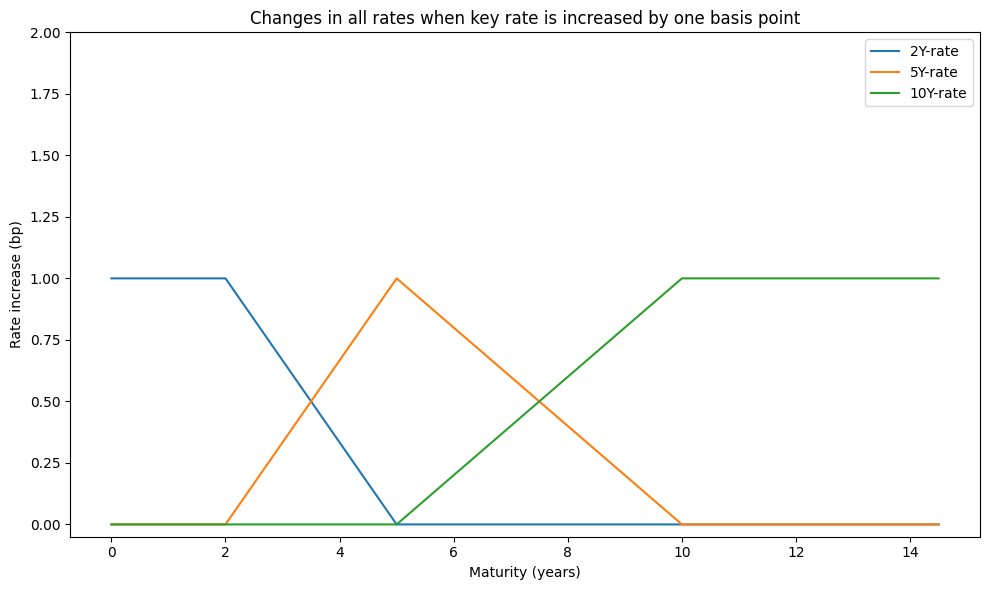

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame.from_dict(DV01, orient='index', columns=[f"{y}Y-rate" for y in KR])\
         .plot(ax=ax)
ax.legend()
ax.set_title('Changes in all rates when key rate is increased by one basis point')
ax.set_ylabel('Rate increase (bp)')
ax.set_xlabel('Maturity (years)')
ax.set_ylim(top=2)
plt.tight_layout()

## Bond risk factors

In [ ]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

In [36]:
# get Merrill Lynch bond indexes
freq = 'D'    # periodicity 'M' or 'D'
cat = alf.get_category(32413)
print(cat['id'], cat['name'])

32413 BofA Merrill Lynch Total Bond Return Index Values


In [37]:
# get bond index returns
bonds = []   # to accumulate bond returns
for s in cat['series']:
    bonds.append(alf(s['id'], start=19961231, freq=freq) )
bonds_df = pd.concat(bonds, axis=1).sort_index()

In [38]:
# show blocks of data availability
counts = bonds_df.notna().sum(axis=1).rename('count')
counts = pd.concat([counts, (counts != counts.shift()).cumsum().rename('notna')], axis=1)
counts = counts.reset_index().groupby(['notna', 'count'])['date'].agg(['first','last'])
counts

,,first,last
notna,count,,
1,15,19961231,19971230
2,16,19971231,19981230
3,33,19981231,20031230
4,48,20031231,20181108
5,46,20181109,20181109
6,48,20181112,20240418


In [39]:
# choose start date with good data availability
start_date = 19981231
rets = bonds_df.loc[bonds_df.index >= start_date,
                    bonds_df.loc[start_date].notna().values].iloc[:-1]
rets = pd.concat([alf.transform(rets[col], log=1, diff=1)
                  for col in rets.columns], axis=1).dropna()
rets

,BAMLCC0A0CMTRIV,BAMLCC0A1AAATRIV,BAMLCC0A2AATRIV,BAMLCC0A3ATRIV,BAMLCC0A4BBBTRIV,BAMLCC1A013YTRIV,BAMLCC2A035YTRIV,BAMLCC3A057YTRIV,BAMLCC4A0710YTRIV,BAMLCC7A01015YTRIV,...,BAMLEMPTPRVICRPITRIV,BAMLEMRACRPIASIATRIV,BAMLEMRECRPIEMEATRIV,BAMLEMRLCRPILATRIV,BAMLEMUBCRPIUSTRIV,BAMLHE00EHYITRIV,BAMLHYH0A0HYM2TRIV,BAMLHYH0A1BBTRIV,BAMLHYH0A2BTRIV,BAMLHYH0A3CMTRIV
date,,,,,,,,,,,,,,,,,,,,,
19990104,-0.001053,-0.001421,-0.000660,-0.001166,-0.000995,0.000076,0.000473,0.000534,-0.000519,-0.001209,...,0.001599,-0.000700,-0.005616,0.002297,0.001099,0.000195,0.001490,0.000250,0.001999,0.003234
19990105,-0.003846,-0.004194,-0.003500,-0.003857,-0.003952,-0.000844,-0.002452,-0.003343,-0.004276,-0.004990,...,0.002692,0.000400,0.008113,0.002392,0.002394,0.012287,0.000674,-0.000834,0.000781,0.005428
19990106,0.002388,0.002099,0.002102,0.002495,0.002419,0.000466,0.000901,0.001695,0.001967,0.002537,...,0.007144,0.003395,0.009135,0.006251,0.006060,0.000577,0.001487,0.001583,0.001041,0.003480
19990107,-0.002694,-0.002813,-0.002413,-0.002573,-0.002996,0.000101,-0.000853,-0.001561,-0.002662,-0.003371,...,-0.001484,-0.003095,0.007386,0.000198,-0.000694,0.003932,-0.000112,-0.001250,0.000520,0.001005
19990108,-0.002583,-0.002941,-0.002419,-0.002658,-0.002504,-0.000920,-0.002006,-0.003309,-0.003773,-0.004368,...,-0.000594,0.001998,0.000392,-0.002079,-0.000892,0.000000,0.001737,-0.000918,0.002509,0.007643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240411,-0.001330,-0.001659,-0.001234,-0.001240,-0.001418,0.000582,-0.000040,-0.000588,-0.001859,-0.001963,...,-0.001561,-0.000714,-0.003072,-0.003734,-0.002164,-0.001999,-0.001882,-0.001767,-0.001925,-0.002184
20240412,0.001673,0.001828,0.001822,0.001739,0.001592,0.000727,0.001509,0.002151,0.001789,0.002657,...,0.001016,0.001856,0.000311,-0.000522,0.000781,-0.000229,-0.001196,-0.000885,-0.001148,-0.002668
20240415,-0.006152,-0.008150,-0.006125,-0.006174,-0.006110,-0.000410,-0.002345,-0.004446,-0.006793,-0.008662,...,-0.002430,-0.002237,-0.003116,-0.004952,-0.003309,-0.000858,-0.002717,-0.002836,-0.002138,-0.003969


In [40]:
pd.set_option('display.max_colwidth', None)
print("Bond Index Total Returns")
Series(alf.header(rets.columns), index=rets.columns, name='title')\
    .to_frame().rename_axis('series')

Bond Index Total Returns


,title
series,
BAMLCC0A0CMTRIV,ICE BofA US Corporate Index Total Return Index Value
BAMLCC0A1AAATRIV,ICE BofA AAA US Corporate Index Total Return Index Value
BAMLCC0A2AATRIV,ICE BofA AA US Corporate Index Total Return Index Value
BAMLCC0A3ATRIV,ICE BofA Single-A US Corporate Index Total Return Index Value
BAMLCC0A4BBBTRIV,ICE BofA BBB US Corporate Index Total Return Index Value
BAMLCC1A013YTRIV,ICE BofA 1-3 Year US Corporate Index Total Return Index Value
BAMLCC2A035YTRIV,ICE BofA 3-5 Year US Corporate Index Total Return Index Value
BAMLCC3A057YTRIV,ICE BofA 5-7 Year US Corporate Index Total Return Index Value
BAMLCC4A0710YTRIV,ICE BofA 7-10 Year US Corporate Index Total Return Index Value


In [41]:
# Extract principal components of bond index returns
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pipe.fit(rets)
print(pipe.named_steps['pca'].explained_variance_ratio_)  # sanity check
scree = Series(pipe.named_steps['pca'].explained_variance_ratio_,
               index=np.arange(1, rets.shape[1]+1))
DataFrame(scree.cumsum().rename('Cumulative Variance Ratio Explained')).iloc[:10]

[5.90633015e-01 1.84670310e-01 7.66846462e-02 2.31249861e-02
 2.08709778e-02 1.73997768e-02 1.59048070e-02 1.11428201e-02
 1.08065948e-02 9.53333795e-03 7.17195056e-03 5.80339671e-03
 5.13102872e-03 4.61504627e-03 3.95216602e-03 2.55170452e-03
 2.42215195e-03 2.22998793e-03 1.31893510e-03 9.51987980e-04
 7.84773755e-04 6.15732469e-04 3.99797350e-04 3.69901192e-04
 3.07591420e-04 2.74143218e-04 9.27920937e-05 8.50594135e-05
 5.40645899e-05 3.96089404e-05 3.55645916e-05 1.55810718e-05
 5.76269423e-06]


,Cumulative Variance Ratio Explained
1,0.590633
2,0.775303
3,0.851988
4,0.875113
5,0.895984
6,0.913384
7,0.929289
8,0.940431
9,0.951238
10,0.960771


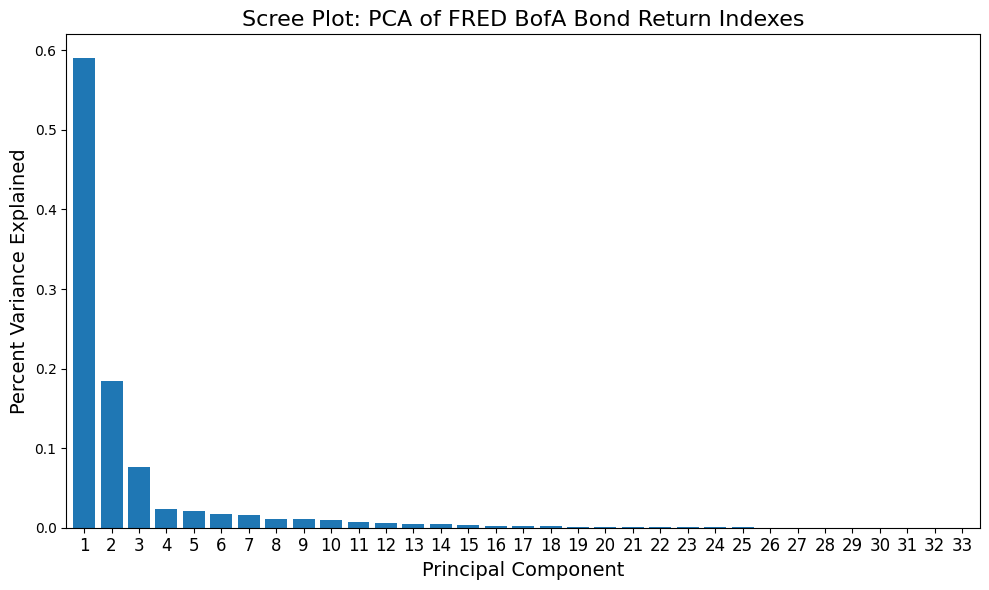

In [42]:
# Scree plot
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
scree.plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: PCA of FRED BofA Bond Return Indexes', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_ylabel("Percent Variance Explained", fontsize=14)
ax.set_xlabel("Principal Component", fontsize=14)
plt.tight_layout()

### Explainability of Statistical Factors

In [43]:
# Extract factor returns from bond indexes with PCA projection
K = 4
factors = DataFrame(pipe.transform(rets)[:, :K],
                    columns=[f"PC{c+1}" for c in range(K)],
                    index=pd.DatetimeIndex(rets.index.astype(str), freq='infer'))

Construct changes in interest rate spreads:
- level: average of 2-year and 10-year treasury rates
- slope: 10-year minus 2-year rates
- twist: (10-year minus 5-year) minus (5-year minus 2-year)
- credit: BAA minus 10-year treasury rates

In [44]:
# Construct interest rate spread changes
spreads = pd.concat([alf(s, freq=freq) for s in ['BAA10Y', 'DGS10', 'DGS5', 'DGS2']],
                     axis=1)\
            .sort_index()
spreads.index = pd.DatetimeIndex(spreads.index.astype(str), freq='infer')
spreads['level'] = 0.5 * (spreads['DGS2'] + spreads['DGS10'])
spreads['credit'] = spreads['BAA10Y']
spreads['slope'] = spreads['DGS10'] - spreads['DGS2']
spreads['twist'] = ((spreads['DGS10'] - spreads['DGS5']) -
                    (spreads['DGS5'] - spreads['DGS2']))
spreads = spreads.drop(columns=['BAA10Y', 'DGS10', 'DGS5', 'DGS2'])\
                 .ffill()\
                 .diff()\
                 .dropna()
spreads

,level,credit,slope,twist
date,,,,
1986-01-03,0.010,-0.04,1.776357e-15,1.776357e-15
1986-01-06,0.015,-0.01,1.000000e-02,-1.000000e-02
1986-01-07,-0.100,0.06,-6.000000e-02,-8.881784e-16
1986-01-08,0.155,-0.14,7.000000e-02,3.000000e-02
1986-01-09,0.160,-0.05,-4.000000e-02,-8.000000e-02
...,...,...,...,...
2024-04-12,-0.055,0.04,-1.000000e-02,3.000000e-02
2024-04-15,0.090,0.01,8.000000e-02,-4.000000e-02
2024-04-16,0.040,0.00,0.000000e+00,0.000000e+00


Text(0.5, 1.0, 'Correlation of bond factors and interest rate spread changes')

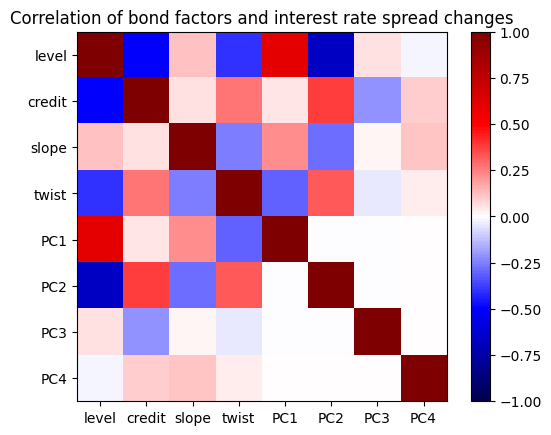

In [45]:
# Show correlations between bond factor returns and spread changes
data = pd.concat([spreads, factors], axis=1, join='inner')
corr = data.corr()
#plt.imshow(corr**2, vmin=0, vmax=1, cmap='Purples')
plt.imshow(corr, vmin=-1, vmax=1, cmap='seismic')
plt.xticks(range(len(corr)), corr.index)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.title('Correlation of bond factors and interest rate spread changes')


In [46]:
# Show regression fits
for pc in range(K):
    print(smf.ols(f"PC{pc+1} ~ credit + level + slope + twist", data=data)\
          .fit(cov_type='HAC', cov_kwds={'maxlags': 63})\
          .summary())

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     422.9
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          2.47e-323
Time:                        13:15:12   Log-Likelihood:                -16027.
No. Observations:                6318   AIC:                         3.206e+04
Df Residuals:                    6313   BIC:                         3.210e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0222      0.091      0.245      0.8